# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, roc_curve, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loading Data, Regrouping classes & SMOTE (Synthetic Minority Oversampling Technique)
This code loads the wine dataset, merges the original quality levels into broader class groups, splits the data into train and test sets and applies SMOTE to balance the class distribution by generating synthetic samples for minority classes.


In [2]:
# Loading Data and Grouping
#--------------------------
df = pd.read_csv("winequality-white.csv", sep=";")
X = df.drop("quality", axis=1)
y = df["quality"]
mapping = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 4, 10: 4}
y_to_groups = y.map(mapping)
grouped_labels = {0: "0-4", 1: "5", 2: "6", 3: "7", 4: "8-10"}
y_named = y_to_groups.map(grouped_labels)

# Train-Test splits
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_to_groups,
    test_size=0.2,
    random_state=42,
    stratify=y_to_groups
)

# SMOTE
#------
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Random Forest initialization, fitting & prediction
This code trains a Random Forest Classifier on the SMOTE-balanced data and then produces class predictions and probability outputs for the test set.

In [3]:
# ---- Random Forest ----
rf = RandomForestClassifier(
    n_estimators=350,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features = "sqrt",
    class_weight=None,
    random_state=42
)
rf.fit(X_train_sm, y_train_sm)

# Random Forest Prediction
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

# XGBoost initialization, fitting & prediction
This code trains a XGBoost Classifier on the SMOTE-balanced data and then produces class predictions and probability outputs for the test set.

In [4]:
# ---- XGBoost ----
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.11,
    max_depth=11,
    subsample=0.7,
    random_state=42,
)
xgb.fit(X_train_sm, y_train_sm)

# XGBoost prediction
xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)

# SVM scaling, initialization, fitting & prediction
This code standardizes the features, trains an RBF-kernel SVM on the scaled SMOTE-balanced data, and generates predictions and probability outputs for the test set.

In [5]:
# SCALING FOR SVM
# ---------------
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_sm)
X_test_svm = scaler.transform(X_test)

# ---- SVM RBF ----
svm = SVC(
    kernel="rbf",
    C=50,
    gamma=0.1,
    probability=True,
    random_state=42
)
svm.fit(X_train_svm, y_train_sm)

# SVM RBF Prediction
svm_pred = svm.predict(X_test_svm)
svm_proba = svm.predict_proba(X_test_svm)

# Results
This code computes accuracy, macro F1, macro AUC, precision, and recall for each model and prints a summary to compare their overall performance.

In [6]:
# RESULTS
# -------

# ACCURACY
rf_acc = accuracy_score(y_test, rf_pred)
xgb_acc = accuracy_score(y_test, xgb_pred)
svm_acc = accuracy_score(y_test, svm_pred)

# MACRO F1
rf_f1 = f1_score(y_test, rf_pred, average='macro')
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
svm_f1 = f1_score(y_test, svm_pred, average='macro')

# MACRO AUC (OVR)
rf_auc = roc_auc_score(y_test, rf_proba, multi_class='ovr')
xgb_auc = roc_auc_score(y_test, xgb_proba, multi_class='ovr')
svm_auc = roc_auc_score(y_test, svm_proba, multi_class='ovr')

# PRESICION
rf_prec = precision_score(y_test, rf_pred, average='macro')
xgb_prec = precision_score(y_test, xgb_pred, average='macro')
svm_prec = precision_score(y_test, svm_pred, average='macro')

#RECALL
rf_rec = recall_score(y_test, rf_pred, average='macro')
xgb_rec = recall_score(y_test, xgb_pred, average='macro')
svm_rec = recall_score(y_test, svm_pred, average='macro')

# PRINT SUMMARY
print("\n--- MODEL PERFORMANCE ---")
print(f"Random Forest -> Accuracy: {rf_acc:.4f},  Macro F1: {rf_f1:.4f},  Macro AUC: {rf_auc:.4f}")
print(f"XGBoost       -> Accuracy: {xgb_acc:.4f},  Macro F1: {xgb_f1:.4f},  Macro AUC: {xgb_auc:.4f}")
print(f"SVM RBF       -> Accuracy: {svm_acc:.4f},  Macro F1: {svm_f1:.4f},  Macro AUC: {svm_auc:.4f}")


--- MODEL PERFORMANCE ---
Random Forest -> Accuracy: 0.6306,  Macro F1: 0.5464,  Macro AUC: 0.8796
XGBoost       -> Accuracy: 0.6459,  Macro F1: 0.5656,  Macro AUC: 0.8730
SVM RBF       -> Accuracy: 0.5531,  Macro F1: 0.4765,  Macro AUC: 0.7936


# Visualizing Multi-Class AUC Performance with ROC Curves and AUC Barplots
This code computes macro-averaged ROC curves for each model, plots them for visual comparison, and creates a bar chart of their AUC scores to highlight overall predictive performance.

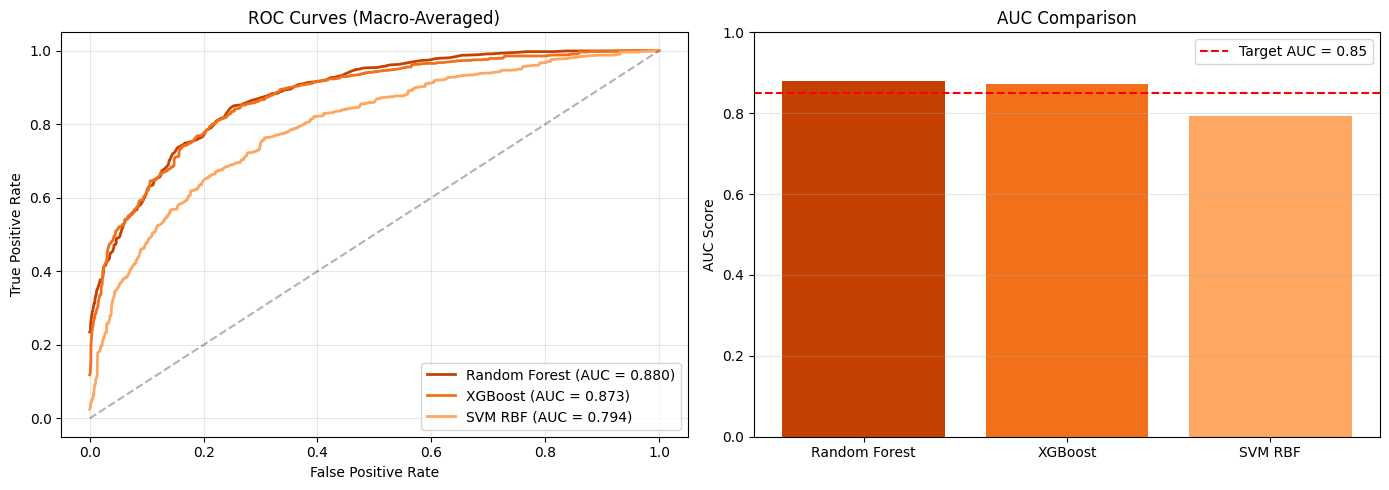

In [7]:
#AUC Scores plots
cmap = plt.colormaps["Oranges"]
colors = [cmap(0.8), cmap(0.6), cmap(0.4)]

rf_auc  = roc_auc_score(y_test, rf_proba, multi_class="ovr")
xgb_auc = roc_auc_score(y_test, xgb_proba, multi_class="ovr")
svm_auc = roc_auc_score(y_test, svm_proba, multi_class="ovr")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Binarize labels for multi-class ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Function to compute macro-average ROC
def macro_roc(proba):
    fpr_dict = {}
    tpr_dict = {}

    for i in range(len(classes)):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])

    # Create common FPR grid
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes))]))

    # Average TPR per FPR point
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= len(classes)

    return all_fpr, mean_tpr

# Compute ROC for each model
fpr_rf, tpr_rf     = macro_roc(rf_proba)
fpr_xgb, tpr_xgb   = macro_roc(xgb_proba)
fpr_svm, tpr_svm   = macro_roc(svm_proba)

# ---- PLOT ROC CURVES ----
ax[0].plot(fpr_rf,  tpr_rf,  color=colors[0], label=f"Random Forest (AUC = {rf_auc:.3f})", linewidth=2)
ax[0].plot(fpr_xgb, tpr_xgb, color=colors[1], label=f"XGBoost (AUC = {xgb_auc:.3f})", linewidth=2)
ax[0].plot(fpr_svm, tpr_svm, color=colors[2], label=f"SVM RBF (AUC = {svm_auc:.3f})", linewidth=2)

ax[0].plot([0,1], [0,1], "k--", alpha=0.3)
ax[0].set_title("ROC Curves (Macro-Averaged)", fontsize=12)
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()
ax[0].grid(alpha=0.3)

# ---- AUC BARPLOT ----
model_names = ["Random Forest", "XGBoost", "SVM RBF"]
auc_values = [rf_auc, xgb_auc, svm_auc]

ax[1].bar(model_names, auc_values, color=colors)
ax[1].axhline(0.85, color="red", linestyle="--", label="Target AUC = 0.85")

ax[1].set_ylim(0, 1)
ax[1].set_ylabel("AUC Score")
ax[1].set_title("AUC Comparison", fontsize=12)
ax[1].legend()
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("roc_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()
individual_models = {
    "Random_Forest": (rf_proba, rf_auc),
    "XGBoost": (xgb_proba, xgb_auc),
    "SVM_RBF": (svm_proba, svm_auc)
}

for model_name, (proba, auc_value) in individual_models.items():

    # Compute macro-averaged ROC again
    fpr, tpr = macro_roc(proba)

    # Create a NEW figure for each ROC curve
    fig, ax_single = plt.subplots(figsize=(6, 5))

    ax_single.plot(fpr, tpr, color=cmap(0.7), linewidth=2,
                   label=f"{model_name.replace('_',' ')} (AUC = {auc_value:.3f})")

    ax_single.plot([0,1], [0,1], "k--", alpha=0.3)
    ax_single.set_title(f"ROC Curve — {model_name.replace('_',' ')}", fontsize=12)
    ax_single.set_xlabel("False Positive Rate")
    ax_single.set_ylabel("True Positive Rate")
    ax_single.legend()
    ax_single.grid(alpha=0.3)

    plt.tight_layout()
    fig.savefig(f"roc_{model_name}.pdf", format="pdf", bbox_inches="tight")
    plt.close(fig)


# Feature importances
Feature importance shows how much each input variable contributed to the model's predictions.
Higher values mean the feature had a stronger influence on wine quality classification.
<br><b>NB!</b> SVM RBF kernel does not provide native feature importances, because it does not operate through interpretable feature splits like tree-based models.


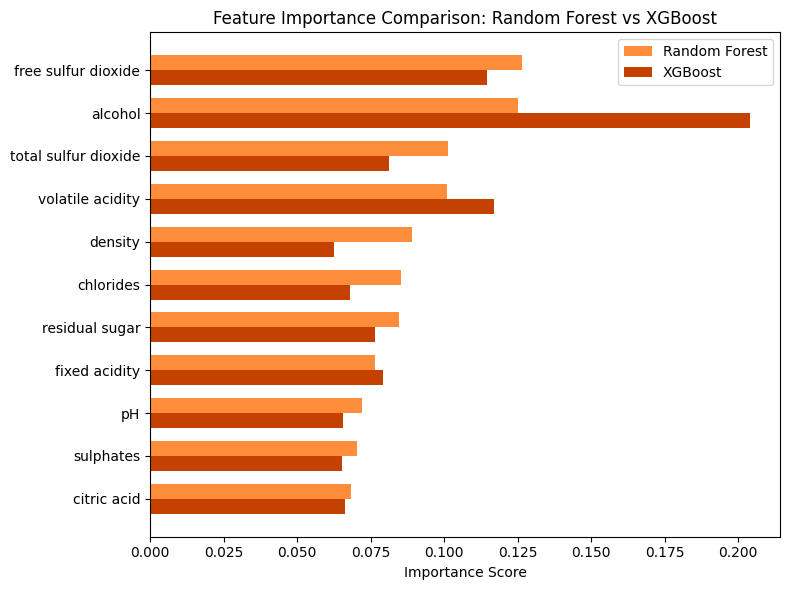

In [8]:
# --- Random Forest feature importances ---
rf_importances = rf.feature_importances_
rf_features = X.columns

rf_df = pd.DataFrame({
    "feature": rf_features,
    "importance": rf_importances
}).sort_values(by="importance", ascending=False)

# --- XGBoost feature importances ---
xgb_importances = xgb.feature_importances_
xgb_features = X.columns

xgb_df = pd.DataFrame({
    "feature": xgb_features,
    "importance": xgb_importances
}).sort_values(by="importance", ascending=False)

# ---------------------
features = rf_df["feature"]
rf_vals = rf_df["importance"].values
xgb_vals = xgb_df.set_index("feature").loc[features]["importance"].values

cmap = plt.colormaps["Oranges"]
rf_color = cmap(0.5)
xgb_color = cmap(0.8)

# --- Plot for feature importances ---
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(features))
width = 0.35

plt.barh(y_pos - width/2, rf_vals, height=width, color=rf_color, label="Random Forest")
plt.barh(y_pos + width/2, xgb_vals, height=width, color=xgb_color, label="XGBoost")

plt.yticks(y_pos, features)
plt.gca().invert_yaxis()  # top = most important
plt.xlabel("Importance Score")
plt.title("Feature Importance Comparison: Random Forest vs XGBoost")
plt.legend()
plt.tight_layout()
plt.savefig("feature_importances.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Confusion matrix
This code generates confusion matrices for all three models, displaying both the raw prediction counts and the percentage of correctly and incorrectly classified samples per true class. This helps compare how well each model distinguishes between the grouped wine quality categories.

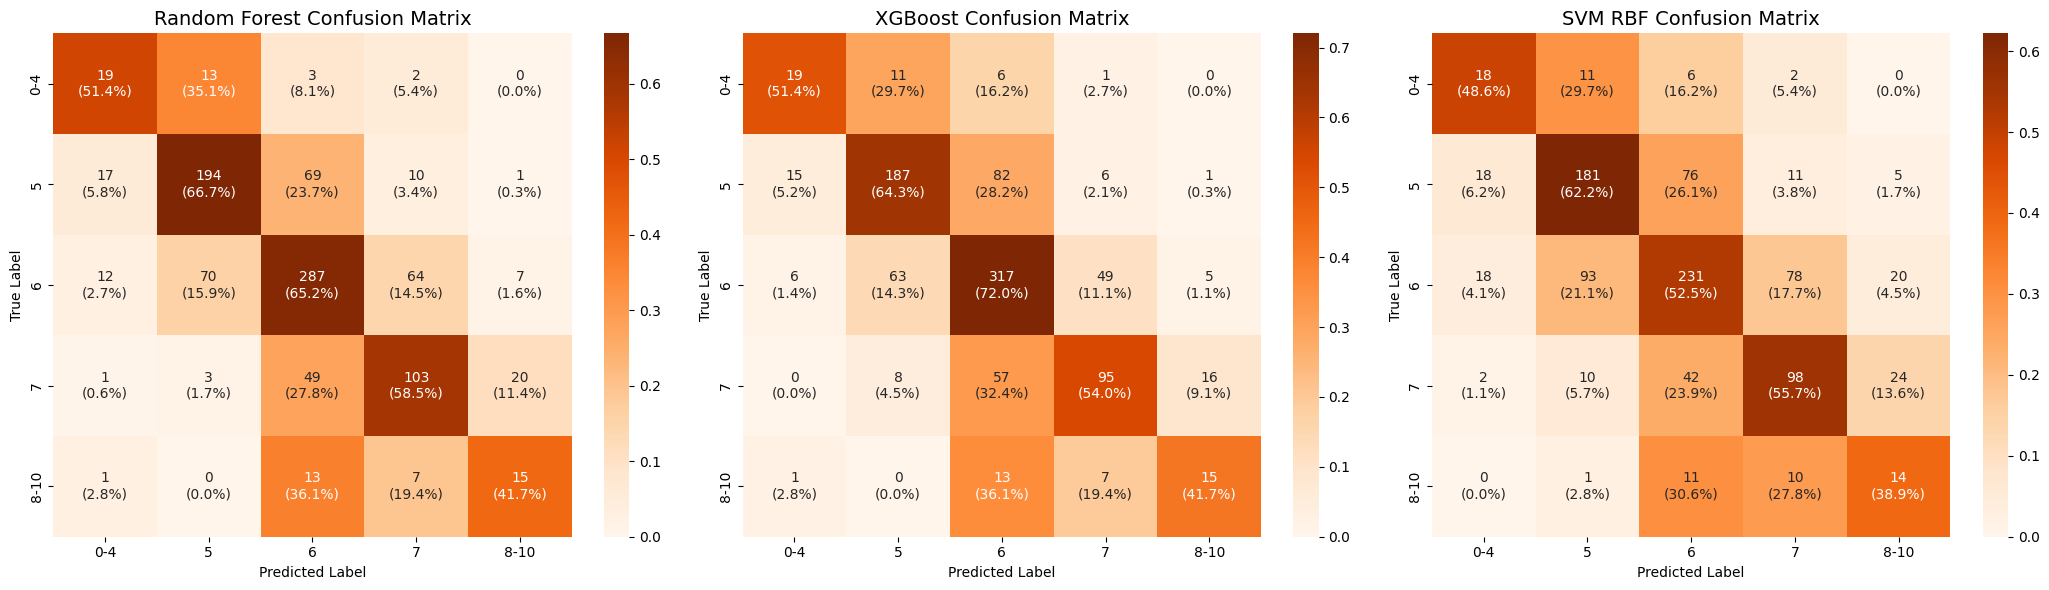

In [9]:
labels = ["0-4", "5", "6", "7", "8-10"]

preds = {
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "SVM RBF": svm_pred
}

fig, axes = plt.subplots(1, 3, figsize=(21, 6))
cmap = plt.colormaps["Oranges"]

for ax, (model_name, y_pred) in zip(axes, preds.items()):
    
    # Absolute counts
    cm_counts = confusion_matrix(y_test, y_pred)

    # Row-normalized percentages
    cm_percent = confusion_matrix(y_test, y_pred, normalize='true')

    # Create annotation matrix: "count\n(XX.X%)"
    annot = np.empty_like(cm_percent).astype(str)
    for i in range(cm_counts.shape[0]):
        for j in range(cm_counts.shape[1]):
            count = cm_counts[i, j]
            pct = cm_percent[i, j] * 100
            annot[i, j] = f"{count}\n({pct:.1f}%)"

    # Draw heatmap
    sns.heatmap(
        cm_percent,
        annot=annot,
        fmt='',
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        cbar=True,
        ax=ax
    )

    ax.set_title(f"{model_name} Confusion Matrix", fontsize=14)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.savefig("confusion_matrices.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Correlation matrix
This code computes the correlation matrix of all dataset features and displays it as a heatmap, helping identify which variables are strongly related and may influence model behavior or redundancy.

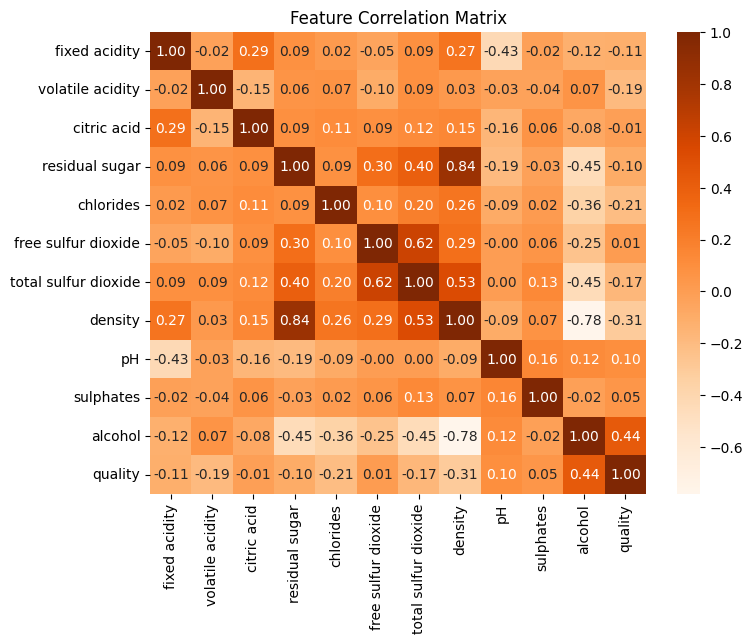

In [10]:
#Correlation matrix heatmap
corr_matrix = df.corr()
cmap = plt.colormaps["Oranges"]
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, cbar=True)
plt.title("Feature Correlation Matrix")
plt.savefig("correlation_matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Comparing Key Classification Metrics Across Models
This code visualizes accuracy, macro precision, macro recall, and macro F1 for all models using grouped bars, a radar chart, and a line plot, making it easy to compare overall performance across multiple evaluation metrics.


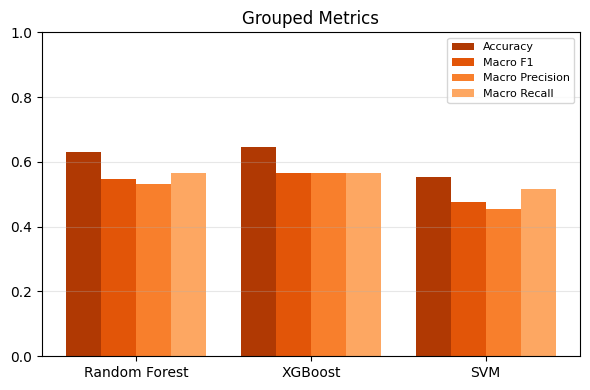

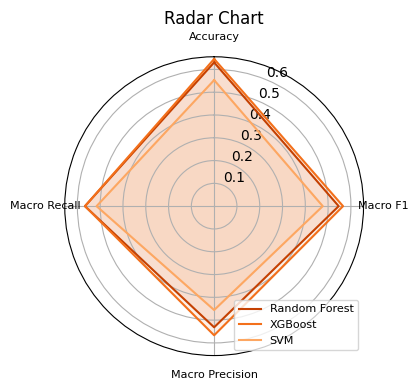

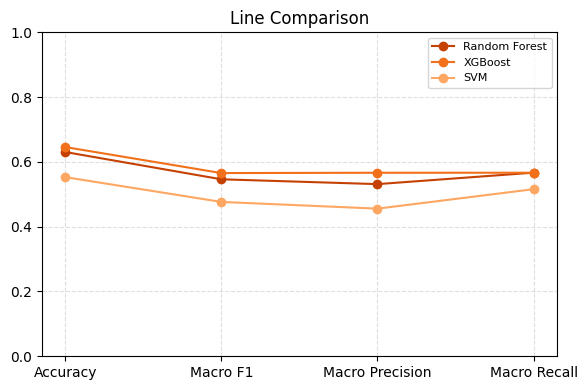

In [11]:
#PLOT FOR ACCURACY, PRESICION, F1 and RECALL COMPARISON 
# (3 different plots to choose from if even needed this kind of plot)
# "Macro" means we look at each class separately, calculate the score for each one,
# and then take the simple average. This way all classes count equally.

cmap = plt.colormaps["Oranges"]
colors = [cmap(0.8), cmap(0.6), cmap(0.4)]

models = ["Random Forest", "XGBoost", "SVM"]
metrics = ["Accuracy", "Macro F1", "Macro Precision", "Macro Recall"]

accuracy   = [rf_acc,  xgb_acc,  svm_acc]
macro_f1   = [rf_f1,   xgb_f1,   svm_f1]
macro_prec = [rf_prec, xgb_prec, svm_prec]
macro_rec  = [rf_rec,  xgb_rec,  svm_rec]



# --- GROUPED BAR CHART (subplot 1) ---
# -------------------------------------

x = np.arange(len(models))
width = 0.2

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.bar(x - 1.5*width, accuracy,   width, label="Accuracy",        color=cmap(0.85))
ax1.bar(x - 0.5*width, macro_f1,   width, label="Macro F1",        color=cmap(0.7))
ax1.bar(x + 0.5*width, macro_prec, width, label="Macro Precision", color=cmap(0.55))
ax1.bar(x + 1.5*width, macro_rec,  width, label="Macro Recall",    color=cmap(0.4))

ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title("Grouped Metrics")
ax1.set_ylim(0, 1)
ax1.legend(fontsize=8)
ax1.grid(axis='y', alpha=0.3)

plt.tight_layout()
fig.savefig("metrics_grouped.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)




# --- RADAR CHART (subplot 2) ---
#--------------------------------
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

def radar_vals(vals):
    return vals + vals[:1]

rf_plot  = radar_vals([rf_acc,  rf_f1,  rf_prec,  rf_rec])
xgb_plot = radar_vals([xgb_acc, xgb_f1, xgb_prec, xgb_rec])
svm_plot = radar_vals([svm_acc, svm_f1, svm_prec, svm_rec])

fig, ax2 = plt.subplots(figsize=(6, 4), subplot_kw={'projection': 'polar'})

ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(metrics, fontsize=8)

ax2.plot(angles, rf_plot,  color=colors[0], label="Random Forest")
ax2.fill(angles, rf_plot,  color=colors[0], alpha=0.1)

ax2.plot(angles, xgb_plot, color=colors[1], label="XGBoost")
ax2.fill(angles, xgb_plot, color=colors[1], alpha=0.1)

ax2.plot(angles, svm_plot, color=colors[2], label="SVM")
ax2.fill(angles, svm_plot, color=colors[2], alpha=0.1)

ax2.set_title("Radar Chart")
ax2.legend(loc="lower right", fontsize=8)

plt.tight_layout()
fig.savefig("metrics_radar.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)


# --- LINE PLOT (subplot 3) ---
# -----------------------------
fig, ax3 = plt.subplots(figsize=(6, 4))

ax3.plot(metrics, [rf_acc, rf_f1, rf_prec, rf_rec], marker='o', color=colors[0], label="Random Forest")
ax3.plot(metrics, [xgb_acc, xgb_f1, xgb_prec, xgb_rec], marker='o', color=colors[1], label="XGBoost")
ax3.plot(metrics, [svm_acc, svm_f1, svm_prec, svm_rec], marker='o', color=colors[2], label="SVM")

ax3.set_ylim(0, 1)
ax3.set_title("Line Comparison")
ax3.grid(True, linestyle='--', alpha=0.4)
ax3.legend(fontsize=8)

plt.tight_layout()
fig.savefig("metrics_line.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)